In [1]:
## Most general notebook 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import gzip

# Form our test and train data
from tensorflow import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import models 
from tensorflow.keras import layers 
from tensorflow.keras import initializers
from tensorflow.keras.models import load_model
#
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
# 
from collections import defaultdict


C:\Users\skypi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\skypi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\skypi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\skypi\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

## Loading the data

In [2]:
# This is the notebook where I load the data 
# Project1/train-images-idx3-ubyte.gz
f_train_im = gzip.open('C:/everything/Courses/EEL6814 - Neural Networks and Deep Learning/Project1/train-images-idx3-ubyte.gz','r')
f_train_lab = gzip.open('C:/everything/Courses/EEL6814 - Neural Networks and Deep Learning/Project1/train-labels-idx1-ubyte.gz','r')
f_test_im = gzip.open('C:/everything/Courses/EEL6814 - Neural Networks and Deep Learning/Project1/t10k-images-idx3-ubyte.gz','r')
f_test_lab = gzip.open('C:/everything/Courses/EEL6814 - Neural Networks and Deep Learning/Project1/t10k-labels-idx1-ubyte.gz','r')
image_size = 28
lab_size = 1
n_train = 60000
n_test = 10000
f_train_im.read(16)
f_train_lab.read(8)
f_test_im.read(16)
f_test_lab.read(8)
buf_tr_im = f_train_im.read(image_size * image_size * n_train)
buf_tr_lab = f_train_lab.read(lab_size * n_train)
buf_test_im = f_test_im.read(image_size * image_size * n_test)
buf_test_lab = f_test_lab.read(lab_size * n_train)
train_im = np.frombuffer(buf_tr_im, dtype=np.uint8).astype(np.float32)
train_im = train_im.reshape(n_train, image_size, image_size, 1)
test_im = np.frombuffer(buf_test_im, dtype=np.uint8).astype(np.float32)
test_im = test_im.reshape(n_test, image_size, image_size, 1)
train_labels = np.frombuffer(buf_tr_lab, dtype=np.uint8).astype(np.int64)
train_labels = train_labels.reshape(n_train,1)
test_labels = np.frombuffer(buf_test_lab, dtype=np.uint8).astype(np.int64)
test_labels = test_labels.reshape(n_test,1)
####### PROCESS THE DATA 
# Data Processing
#scaling 
# reshape the data to be able to be scaled 
Train_Im_Reshaped = train_im.reshape(train_im.shape[0],28*28)
Test_Im_Reshaped = test_im.reshape(test_im.shape[0],28*28)
from sklearn.preprocessing import MinMaxScaler
scl = MinMaxScaler()
scl.fit(Train_Im_Reshaped)
Train_Im_Scaled = scl.transform(Train_Im_Reshaped)
XTest = scl.transform(Test_Im_Reshaped)
#reshape data back to images 
# Train_Im_2d_np = Train_Im_Scaled.reshape(Train_Im_Scaled.shape[0], 28,28,1)
# Test_Im_2d_np  = Test_Im_Scaled.reshape(Test_Im_Scaled.shape[0],28,28,1)
YTrainAll_oneHot = to_categorical(train_labels )
YTest_oneHot = to_categorical(test_labels)
X_Train,X_Val,Y_Train_oneHot,Y_Val_oneHot = train_test_split(Train_Im_Scaled,YTrainAll_oneHot, test_size=0.1, random_state=42, shuffle = True)


## Functions for the network 

In [3]:
def MLP_Create(nhidden1,  nhidden_in = 0,  nHiddenMoreLayers = 0,  dropoutrate = 0):
    # Stop criteria will be a string ; either 'val_loss' or 'val_accuracy'
    nout = 10; #number of output nodes
#     SavePath = '1layer_nh' + str(nhidden) + '_LR_'+ str(lr)+ '_SC_' + StopCriteria + '_batch_' + str(batchnum) +'_OPT_' + optimization +'.h5'
    network = models.Sequential()
    network.add(layers.Dense(nhidden1,activation='sigmoid',input_shape=(28*28,)))
    if dropoutrate > 0: 
        network.add(layers.Dropout(dropoutrate))
    if nHiddenMoreLayers >0 :
        for hiddenLayer in range(nHiddenMoreLayers): 
            network.add(layers.Dense(nhidden_in, activation = 'sigmoid'))
    network.add(layers.Dense(nout, activation = 'softmax'))
    return  network

In [4]:
### batchnum, epochs, StopCriteria, optimization,
def Fit_network(network, SavePath , epochs = 500, batchnum = 128, StopCriteria = 'val_loss', optimization = 'adam', lr =.001, loss='categorical_crossentropy',verbose = 1):
    # Optimizer definition
    if optimization == 'adam':
        opt = keras.optimizers.Adam(learning_rate=lr)
    elif optimization == 'SGD':
        opt = keras.optimizers.SGD(learning_rate=lr)
    elif optimization == 'RMSProp':
        opt = keras.optimizers.RMSprop(learning_rate=lr)
    elif optimization == 'Adadelta':
        opt = keras.optimizers.Adadelta(learning_rate=lr)
    elif optimization == 'Adagrad':
        opt = keras.optimizers.Adagrad(learning_rate=lr)
    elif optimization == 'Adamax':
        opt = keras.optimizers.Adamax( learning_rate=lr)
# 
#     SavePath = str() + str(nhidden) + '_LR_'+ str(lr)+ '_SC_' + StopCriteria + '_batch_' + str(batchnum) +'_OPT_' + optimization +'.h5'
    network.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
#     network.save_weights('model_init.h5')
    callbacks = [EarlyStopping(monitor=StopCriteria, patience=20),
             ModelCheckpoint(filepath=SavePath, monitor=StopCriteria, save_best_only=True)]
    history = network.fit(X_Train,Y_Train_oneHot,
                      epochs=epochs,
                      batch_size=batchnum,
                      callbacks=callbacks, # Early stopping
                      validation_data=(X_Val,Y_Val_oneHot),
                         verbose = verbose)
    return history

In [7]:
def create_path(nlayers, nnodes, optimizer = 'adam', lr = 0.001):
    path = 'C:/everything/Courses/EEL6814 - Neural Networks and Deep Learning/Project1/Final/SavedModels/11062020_Model_'+ str(nlayers)+'_layer_'+str(nnodes)+'nodes_'+ optimizer +'_Opt_' + str(lr)+'_LR.h5'
    return path

In [8]:
## try one training
nodes = 350 ; hl = 1 ; AccuracyTesting = 0 ; LossTesting = 0; nrep = 20;
for i in range(nrep):
    net = MLP_Create(nhidden1 = nodes)
    path =  create_path(hl,nodes)
    history_350 = Fit_network(net, path)
    trained_network = load_model(path)
    test_loss, test_acc = trained_network.evaluate(XTest,YTest_oneHot)
    AccuracyTesting += test_acc
    LossTesting += test_loss 

FinalAcc =AccuracyTesting/nrep
FinalLoss = LossTesting/nrep
print(FinalAcc, FinalLoss)

Train on 54000 samples, validate on 6000 samples
Epoch 1/500
54000/54000 [==============================] - 1s 25us/sample - loss: 0.6148 - acc: 0.7932 - val_loss: 0.4597 - val_acc: 0.8375
Epoch 2/500
54000/54000 [==============================] - 1s 22us/sample - loss: 0.4342 - acc: 0.8451 - val_loss: 0.4184 - val_acc: 0.8467
Epoch 3/500
54000/54000 [==============================] - 1s 22us/sample - loss: 0.3933 - acc: 0.8591 - val_loss: 0.3811 - val_acc: 0.8610
Epoch 4/500
54000/54000 [==============================] - 1s 22us/sample - loss: 0.3697 - acc: 0.8669 - val_loss: 0.3693 - val_acc: 0.8665
Epoch 5/500
54000/54000 [==============================] - 1s 23us/sample - loss: 0.3505 - acc: 0.8740 - val_loss: 0.3588 - val_acc: 0.8693
Epoch 6/500
54000/54000 [==============================] - 1s 22us/sample - loss: 0.3351 - acc: 0.8776 - val_loss: 0.3605 - val_acc: 0.8727
Epoch 7/500
54000/54000 [==============================] - 1s 24us/sample - loss: 0.3198 - acc: 0.8841 - val_lo

In [9]:
print(FinalAcc, FinalLoss)

0.8908649981021881 0.3148118580421806


In [36]:
his = Fit_network(net, path)
trained_network = load_model(path)
 test_loss, test_acc = trained_network.evaluate(XTest,YTest_oneHot)

Train on 54000 samples, validate on 6000 samples
Epoch 1/500
54000/54000 [==============================] - 8s 147us/sample - loss: 0.5663 - acc: 0.8019 - val_loss: 0.4571 - val_acc: 0.8347
Epoch 2/500
54000/54000 [==============================] - 4s 80us/sample - loss: 0.4261 - acc: 0.8473 - val_loss: 0.3982 - val_acc: 0.8550
Epoch 3/500
54000/54000 [==============================] - 4s 80us/sample - loss: 0.3911 - acc: 0.8605 - val_loss: 0.3874 - val_acc: 0.8545
Epoch 4/500
54000/54000 [==============================] - 4s 77us/sample - loss: 0.3657 - acc: 0.8691 - val_loss: 0.3595 - val_acc: 0.8702
Epoch 5/500
54000/54000 [==============================] - 4s 76us/sample - loss: 0.3459 - acc: 0.8733 - val_loss: 0.3477 - val_acc: 0.8740
Epoch 6/500
54000/54000 [==============================] - 4s 77us/sample - loss: 0.3301 - acc: 0.8794 - val_loss: 0.3721 - val_acc: 0.8625
Epoch 7/500
54000/54000 [==============================] - 4s 77us/sample - loss: 0.3162 - acc: 0.8844 - val_l

## Optimization for learning rate

In [11]:
## Optimize for learning rate : 
# Looping over learning rates and storing the results 
LR_array = [1e-4, 1e-3, 1e-2, .1, 1, 10]
# LR_array = [.1]
batchnum = 128; StopCriteria = 'val_loss'; epochs = 500; nhidden = 350; nhiddenlayers = 1

npoints = len(LR_array)
d_lr = defaultdict(lambda: "Not Present") 
d_lr["train_acc_arr"] = defaultdict(lambda: "Not Present")
d_lr["train_loss_arr"] = defaultdict(lambda: "Not Present")
d_lr["val_acc_arr"] = defaultdict(lambda: "Not Present")
d_lr["val_loss_arr"] = defaultdict(lambda: "Not Present")
# make accuracy and loss list 
test_acc_diff_lr = np.zeros(npoints)
test_loss_diff_lr = np.zeros(npoints)
# loop over hidden layers 
for i in range(npoints):
    LearningRate = LR_array[i]
    path = create_path(nhiddenlayers,nhidden, lr = LearningRate)
    print('working on learning rate  = '+ str(    LearningRate ))
    #create network
    network = MLP_Create(nhidden)
    #fit
    History = Fit_network(network, path , lr =LearningRate, verbose = 0)
    
    key = str(LearningRate)
    d_lr["train_acc_arr"][key] = History.history['acc']
    d_lr["train_loss_arr"][key]  = History.history['loss']
    d_lr["val_acc_arr"][key] = History.history['val_acc']
    d_lr["val_loss_arr"][key] = History.history['val_loss']
    # test the network on the testing data
    trained_network = load_model(path)
    test_loss, test_acc = trained_network.evaluate(XTest,YTest_oneHot)
    test_acc_diff_lr[i] = test_acc
    test_loss_diff_lr[i] = test_loss

#Get epochs array
epoch_arr = np.zeros(npoints)
i=0
for key in d_lr["train_acc_arr"]:
    arr = d_lr["train_acc_arr"][key]
    epoch_arr[i] = len(arr) - 20
    i=i+1

    #######
d_LR_TBS =defaultdict(lambda: "Not Present") 
d_LR_TBS["train_acc_arr"] = dict(d_lr["train_acc_arr"] )
d_LR_TBS["train_loss_arr"] = dict(d_lr["train_loss_arr"])
d_LR_TBS["val_acc_arr"] = dict(d_lr["val_acc_arr"])
d_LR_TBS["val_loss_arr"] = dict(d_lr["val_loss_arr"])
d_LR_TBS['test_acc'] = test_acc_diff_lr
d_LR_TBS['test_loss'] = test_loss_diff_lr
d_LR_TBS['epochs'] = epoch_arr 
d_LR_TBS['LR_vals'] = LR_array
# d_LR_TBS['Description'] = 'Optimization for learning rate_Adam_1layer_ '+ str (nhidden) + '_nodes'
d_LR_TBS = dict(d_LR_TBS)
np.save('dict_LR_Adam_1layer_350_nodes', np.array(d_LR_TBS), allow_pickle = True)
    


working on learning rate  = 0.0001
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
10000/10000 [==============================] - 0s 24us/sample - loss: 0.3123 - acc: 0.8897
working on learning rate  = 0.001
10000/10000 [==============================] - 0s 25us/sample - loss: 0.3144 - acc: 0.8879
working on learning rate  = 0.01
10000/10000 [==============================] - 0s 27us/sample - loss: 0.3825 - acc: 0.8686
working on learning rate  = 0.1
10000/10000 [==============================] - 0s 27us/sample - loss: 0.6094 - acc: 0.8044
working on learning rate  = 1
10000/10000 [==============================] - 0s 29us/sample - loss: 8.5289 - acc: 0.5759
working on learning rate  =

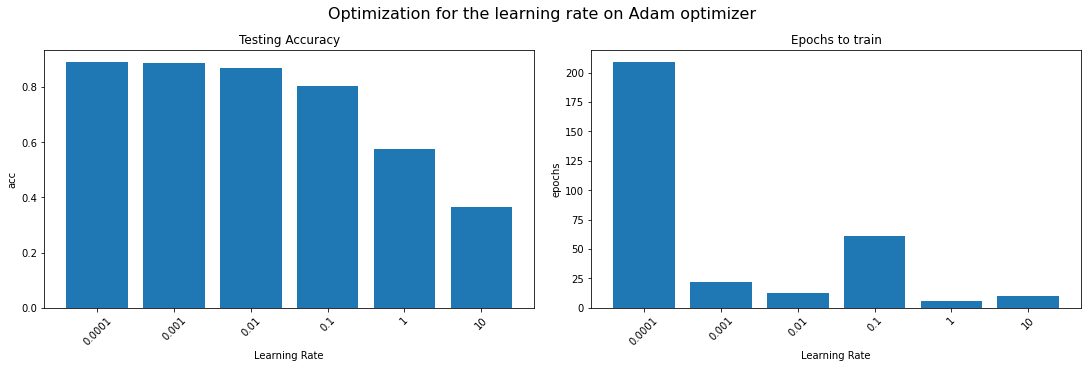

In [18]:
fig, axs = plt.subplots(1, 2,figsize=(15,5), constrained_layout = True)
epoch_arr = d_LR_TBS['epochs']
test_arr = d_LR_TBS['test_acc'] 

a = np.arange(npoints)


axs[0].bar(a, test_arr)
axs[0].set_title('Testing Accuracy')
# axs[0].scatter(a, test_arr)
axs[0].set(xlabel='Learning Rate', ylabel = 'acc')
axs[0].xaxis.set_ticks(a) #set the ticks to be a
axs[0].xaxis.set_ticklabels(LR_array,rotation=45)
# ####
# plt.xticks(rotation='vertical')
axs[1].bar(a, epoch_arr)
axs[1].set_title('Epochs to train')
axs[1].set(xlabel='Learning Rate', ylabel = 'epochs')
axs[1].xaxis.set_ticks(a) #set the ticks to be a
axs[1].xaxis.set_ticklabels(LR_array,rotation=45) # change the ticks' names to x

fig.suptitle('Optimization for the learning rate on Adam optimizer ', fontsize=16)
plt.show()

In [16]:
test_acc_diff_lr

array([0.8897    , 0.88789999, 0.86860001, 0.80440003, 0.57590002,
       0.36629999])

## Optimization for Optimizer

In [41]:
## Optimize for learning rate : 
# Looping over learning rates and storing the results 
Opt_Arr = ['adam', 'SGD', 'RMSProp', 'Adadelta', 'Adagrad','Adamax']
# LR_array = [.1]
batchnum = 128; StopCriteria = 'val_loss'; epochs = 500; nhidden = 350; nhiddenlayers = 1

npoints = len(Opt_Arr)
d_Opt = defaultdict(lambda: "Not Present") 
d_Opt["train_acc_arr"] = defaultdict(lambda: "Not Present")
d_Opt["train_loss_arr"] = defaultdict(lambda: "Not Present")
d_Opt["val_acc_arr"] = defaultdict(lambda: "Not Present")
d_Opt["val_loss_arr"] = defaultdict(lambda: "Not Present")
# make accuracy and loss list 
test_acc_Opt = np.zeros(npoints)
test_loss_Opt = np.zeros(npoints)
# loop over hidden layers 
for i in range(npoints):
    opt = Opt_Arr[i]
    key = opt
    path = create_path(nhiddenlayers,nhidden,optimizer = opt)
    print('working on Optimizer  = '+ opt)
    #create network
    network = MLP_Create(nhidden)
    #fit
    History = Fit_network(network, path , optimization = opt, verbose = 0)
    
#     key = str(LearningRate)
    d_Opt["train_acc_arr"][key] = History.history['acc']
    d_Opt["train_loss_arr"][key]  = History.history['loss']
    d_Opt["val_acc_arr"][key] = History.history['val_acc']
    d_Opt["val_loss_arr"][key] = History.history['val_loss']
    # test the network on the testing data
    trained_network = load_model(path)
    test_loss, test_acc = trained_network.evaluate(XTest,YTest_oneHot)
    test_acc_Opt[i] = test_acc
    test_loss_Opt[i] = test_loss

#Get epochs array
epoch_arr = np.zeros(npoints)
i=0
for key in d_Opt["train_acc_arr"]:
    arr = d_Opt["train_acc_arr"][key]
    epoch_arr[i] = len(arr) - 20
    i=i+1

    #######
d_Opt_TBS =defaultdict(lambda: "Not Present") 
d_Opt_TBS["train_acc_arr"] = dict(d_Opt["train_acc_arr"] )
d_Opt_TBS["train_loss_arr"] = dict(d_Opt["train_loss_arr"])
d_Opt_TBS["val_acc_arr"] = dict(d_Opt["val_acc_arr"])
d_Opt_TBS["val_loss_arr"] = dict(d_Opt["val_loss_arr"])
d_Opt_TBS['test_acc'] = test_acc_Opt
d_Opt_TBS['test_loss'] = test_loss_Opt
d_Opt_TBS['epochs'] = epoch_arr 
d_Opt_TBS['opt_vals'] = Opt_Arr
# d_LR_TBS['Description'] = 'Optimization for learning rate_Adam_1layer_ '+ str (nhidden) + '_nodes'
d_Opt_TBS = dict(d_Opt_TBS)
np.save('dict_Opt_1layer_350_nodes', np.array(d_Opt_TBS), allow_pickle = True)
    


working on Optimizer  = adam
10000/10000 [==============================] - 2s 234us/sample - loss: 0.3126 - acc: 0.8915
working on Optimizer  = SGD
10000/10000 [==============================] - 2s 219us/sample - loss: 0.4906 - acc: 0.8244
working on Optimizer  = RMSProp
10000/10000 [==============================] - 3s 258us/sample - loss: 0.3199 - acc: 0.8904
working on Optimizer  = Adadelta
10000/10000 [==============================] - 7s 749us/sample - loss: 0.5565 - acc: 0.8062s -
working on Optimizer  = Adagrad
10000/10000 [==============================] - 3s 267us/sample - loss: 0.4676 - acc: 0.8345
working on Optimizer  = Adamax
10000/10000 [==============================] - 2s 210us/sample - loss: 0.3147 - acc: 0.8907


## Optimization for number of hidden layers 

Nodes = 20

In [37]:
## Optimize for learning rate : 
# Looping over learning rates and storing the results 
Layers_arr = np.array([1,2,3,4,5,6])
# LR_array = [.1]
batchnum = 128; StopCriteria = 'val_loss'; epochs = 500; nhidden = 20;

npoints = len(Layers_arr)
d_layers = defaultdict(lambda: "Not Present") 
d_layers["train_acc_arr"] = defaultdict(lambda: "Not Present")
d_layers["train_loss_arr"] = defaultdict(lambda: "Not Present")
d_layers["val_acc_arr"] = defaultdict(lambda: "Not Present")
d_layers["val_loss_arr"] = defaultdict(lambda: "Not Present")
# make accuracy and loss list 
test_acc_layers = np.zeros(npoints)
test_loss_d_layers = np.zeros(npoints)
# loop over hidden layers 
for i in range(npoints):
    Layers = Layers_arr[i]
    arg_layer = Layers - 1
    key = str(Layers)
    path = create_path(nlayers = Layers, nnodes = nhidden )
    print('working with  = '+ str(    Layers ) + ' hidden layers and nodes = ' + str(nhidden))
    #create network
#     network = MLP_Create(nhidden)
    network  = MLP_Create(nhidden1 = nhidden,  nhidden_in = nhidden,  nHiddenMoreLayers = arg_layer)
    #fit
    History = Fit_network(network, path , verbose = 0)
    d_layers["train_acc_arr"][key] = History.history['acc']
    d_layers["train_loss_arr"][key]  = History.history['loss']
    d_layers["val_acc_arr"][key] = History.history['val_acc']
    d_layers["val_loss_arr"][key] = History.history['val_loss']
    # test the network on the testing data
    trained_network = load_model(path)
    test_loss, test_acc = trained_network.evaluate(XTest,YTest_oneHot)
    test_acc_layers[i] = test_acc
    test_loss_d_layers[i] = test_loss

#Get epochs array
epoch_arr = np.zeros(npoints)
i=0
for key in d_layers["train_acc_arr"]:
    arr = d_layers["train_acc_arr"][key]
    epoch_arr[i] = len(arr) - 20
    i=i+1

    #######

d_layers_TBS =defaultdict(lambda: "Not Present") 
d_layers_TBS["train_acc_arr"] = dict(d_layers["train_acc_arr"] )
d_layers_TBS["train_loss_arr"] = dict(d_layers["train_loss_arr"])
d_layers_TBS["val_acc_arr"] = dict(d_layers["val_acc_arr"])
d_layers_TBS["val_loss_arr"] = dict(d_layers["val_loss_arr"])
d_layers_TBS['test_acc'] = test_acc_layers
d_layers_TBS['test_loss'] = test_loss_d_layers
d_layers_TBS['epochs'] = epoch_arr 
d_layers_TBS['hidden_layers_vals'] = Layers_arr
# d_LR_TBS['Description'] = 'Optimization for learning rate_Adam_1layer_ '+ str (nhidden) + '_nodes'
d_layers_TBS = dict(d_layers_TBS)
np.save('dict_Diff_hiddenLayers_20_nodes_Adam_0.001', np.array(d_layers_TBS), allow_pickle = True)
    

working with  = 1 hidden layers and nodes = 20
10000/10000 [==============================] - 1s 77us/sample - loss: 0.3751 - acc: 0.8675
working with  = 2 hidden layers and nodes = 20
10000/10000 [==============================] - 1s 81us/sample - loss: 0.3725 - acc: 0.8675
working with  = 3 hidden layers and nodes = 20
10000/10000 [==============================] - 1s 85us/sample - loss: 0.3796 - acc: 0.8656
working with  = 4 hidden layers and nodes = 20
10000/10000 [==============================] - 1s 86us/sample - loss: 0.4031 - acc: 0.8619
working with  = 5 hidden layers and nodes = 20
10000/10000 [==============================] - 1s 91us/sample - loss: 0.4847 - acc: 0.8461
working with  = 6 hidden layers and nodes = 20
10000/10000 [==============================] - 1s 94us/sample - loss: 0.5402 - acc: 0.8312


In [38]:
## Optimize for learning rate : 
# Looping over learning rates and storing the results 
Layers_arr = np.array([1,2,3,4,5,6])
# LR_array = [.1]
batchnum = 128; StopCriteria = 'val_loss'; epochs = 500; nhidden = 40;

npoints = len(Layers_arr)
d_layers = defaultdict(lambda: "Not Present") 
d_layers["train_acc_arr"] = defaultdict(lambda: "Not Present")
d_layers["train_loss_arr"] = defaultdict(lambda: "Not Present")
d_layers["val_acc_arr"] = defaultdict(lambda: "Not Present")
d_layers["val_loss_arr"] = defaultdict(lambda: "Not Present")
# make accuracy and loss list 
test_acc_layers = np.zeros(npoints)
test_loss_d_layers = np.zeros(npoints)
# loop over hidden layers 
for i in range(npoints):
    Layers = Layers_arr[i]
    arg_layer = Layers - 1
    key = str(Layers)
    path = create_path(nlayers = Layers, nnodes = nhidden )
    print('working with  = '+ str(    Layers ) + ' hidden layers and nodes = ' + str(nhidden))
    #create network
#     network = MLP_Create(nhidden)
    network  = MLP_Create(nhidden1 = nhidden,  nhidden_in = nhidden,  nHiddenMoreLayers = arg_layer)
    #fit
    History = Fit_network(network, path , verbose = 0)
    d_layers["train_acc_arr"][key] = History.history['acc']
    d_layers["train_loss_arr"][key]  = History.history['loss']
    d_layers["val_acc_arr"][key] = History.history['val_acc']
    d_layers["val_loss_arr"][key] = History.history['val_loss']
    # test the network on the testing data
    trained_network = load_model(path)
    test_loss, test_acc = trained_network.evaluate(XTest,YTest_oneHot)
    test_acc_layers[i] = test_acc
    test_loss_d_layers[i] = test_loss

#Get epochs array
epoch_arr = np.zeros(npoints)
i=0
for key in d_layers["train_acc_arr"]:
    arr = d_layers["train_acc_arr"][key]
    epoch_arr[i] = len(arr) - 20
    i=i+1

    #######

d_layers_TBS =defaultdict(lambda: "Not Present") 
d_layers_TBS["train_acc_arr"] = dict(d_layers["train_acc_arr"] )
d_layers_TBS["train_loss_arr"] = dict(d_layers["train_loss_arr"])
d_layers_TBS["val_acc_arr"] = dict(d_layers["val_acc_arr"])
d_layers_TBS["val_loss_arr"] = dict(d_layers["val_loss_arr"])
d_layers_TBS['test_acc'] = test_acc_layers
d_layers_TBS['test_loss'] = test_loss_d_layers
d_layers_TBS['epochs'] = epoch_arr 
d_layers_TBS['hidden_layers_vals'] = Layers_arr
# d_LR_TBS['Description'] = 'Optimization for learning rate_Adam_1layer_ '+ str (nhidden) + '_nodes'
d_layers_TBS = dict(d_layers_TBS)
np.save('dict_Diff_hiddenLayers_40_nodes_Adam_0.001', np.array(d_layers_TBS), allow_pickle = True)
    

working with  = 1 hidden layers and nodes = 40
10000/10000 [==============================] - 1s 123us/sample - loss: 0.3421 - acc: 0.8808
working with  = 2 hidden layers and nodes = 40
10000/10000 [==============================] - 1s 121us/sample - loss: 0.3462 - acc: 0.8785
working with  = 3 hidden layers and nodes = 40
10000/10000 [==============================] - 1s 133us/sample - loss: 0.3539 - acc: 0.8762
working with  = 4 hidden layers and nodes = 40
10000/10000 [==============================] - 2s 154us/sample - loss: 0.3932 - acc: 0.8693s - loss: 0.4058 - ac
working with  = 5 hidden layers and nodes = 40
10000/10000 [==============================] - 2s 150us/sample - loss: 0.4291 - acc: 0.8665
working with  = 6 hidden layers and nodes = 40
10000/10000 [==============================] - 2s 187us/sample - loss: 0.5239 - acc: 0.8357


In [39]:
## Optimize for learning rate : 
# Looping over learning rates and storing the results 
Layers_arr = np.array([1,2,3,4,5,6])
# LR_array = [.1]
batchnum = 128; StopCriteria = 'val_loss'; epochs = 500; nhidden = 60;

npoints = len(Layers_arr)
d_layers = defaultdict(lambda: "Not Present") 
d_layers["train_acc_arr"] = defaultdict(lambda: "Not Present")
d_layers["train_loss_arr"] = defaultdict(lambda: "Not Present")
d_layers["val_acc_arr"] = defaultdict(lambda: "Not Present")
d_layers["val_loss_arr"] = defaultdict(lambda: "Not Present")
# make accuracy and loss list 
test_acc_layers = np.zeros(npoints)
test_loss_d_layers = np.zeros(npoints)
# loop over hidden layers 
for i in range(npoints):
    Layers = Layers_arr[i]
    arg_layer = Layers - 1
    key = str(Layers)
    path = create_path(nlayers = Layers, nnodes = nhidden )
    print('working with  = '+ str(    Layers ) + ' hidden layers and nodes = ' + str(nhidden))
    #create network
#     network = MLP_Create(nhidden)
    network  = MLP_Create(nhidden1 = nhidden,  nhidden_in = nhidden,  nHiddenMoreLayers = arg_layer)
    #fit
    History = Fit_network(network, path , verbose = 0)
    d_layers["train_acc_arr"][key] = History.history['acc']
    d_layers["train_loss_arr"][key]  = History.history['loss']
    d_layers["val_acc_arr"][key] = History.history['val_acc']
    d_layers["val_loss_arr"][key] = History.history['val_loss']
    # test the network on the testing data
    trained_network = load_model(path)
    test_loss, test_acc = trained_network.evaluate(XTest,YTest_oneHot)
    test_acc_layers[i] = test_acc
    test_loss_d_layers[i] = test_loss

#Get epochs array
epoch_arr = np.zeros(npoints)
i=0
for key in d_layers["train_acc_arr"]:
    arr = d_layers["train_acc_arr"][key]
    epoch_arr[i] = len(arr) - 20
    i=i+1

    #######

d_layers_TBS =defaultdict(lambda: "Not Present") 
d_layers_TBS["train_acc_arr"] = dict(d_layers["train_acc_arr"] )
d_layers_TBS["train_loss_arr"] = dict(d_layers["train_loss_arr"])
d_layers_TBS["val_acc_arr"] = dict(d_layers["val_acc_arr"])
d_layers_TBS["val_loss_arr"] = dict(d_layers["val_loss_arr"])
d_layers_TBS['test_acc'] = test_acc_layers
d_layers_TBS['test_loss'] = test_loss_d_layers
d_layers_TBS['epochs'] = epoch_arr 
d_layers_TBS['hidden_layers_vals'] = Layers_arr
# d_LR_TBS['Description'] = 'Optimization for learning rate_Adam_1layer_ '+ str (nhidden) + '_nodes'
d_layers_TBS = dict(d_layers_TBS)
np.save('dict_Diff_hiddenLayers_60_nodes_Adam_0.001', np.array(d_layers_TBS), allow_pickle = True)
    

working with  = 1 hidden layers and nodes = 60
10000/10000 [==============================] - 1s 138us/sample - loss: 0.3366 - acc: 0.8797
working with  = 2 hidden layers and nodes = 60
10000/10000 [==============================] - 1s 134us/sample - loss: 0.3347 - acc: 0.8812
working with  = 3 hidden layers and nodes = 60
10000/10000 [==============================] - 2s 162us/sample - loss: 0.3441 - acc: 0.8784
working with  = 4 hidden layers and nodes = 60
10000/10000 [==============================] - 2s 168us/sample - loss: 0.3628 - acc: 0.8730
working with  = 5 hidden layers and nodes = 60
10000/10000 [==============================] - 2s 160us/sample - loss: 0.3917 - acc: 0.8715
working with  = 6 hidden layers and nodes = 60
10000/10000 [==============================] - 2s 193us/sample - loss: 0.5110 - acc: 0.8362


In [40]:
## Optimize for learning rate : 
# Looping over learning rates and storing the results 
Layers_arr = np.array([1,2,3,4,5,6])
# LR_array = [.1]
batchnum = 128; StopCriteria = 'val_loss'; epochs = 500; nhidden = 80;

npoints = len(Layers_arr)
d_layers = defaultdict(lambda: "Not Present") 
d_layers["train_acc_arr"] = defaultdict(lambda: "Not Present")
d_layers["train_loss_arr"] = defaultdict(lambda: "Not Present")
d_layers["val_acc_arr"] = defaultdict(lambda: "Not Present")
d_layers["val_loss_arr"] = defaultdict(lambda: "Not Present")
# make accuracy and loss list 
test_acc_layers = np.zeros(npoints)
test_loss_d_layers = np.zeros(npoints)
# loop over hidden layers 
for i in range(npoints):
    Layers = Layers_arr[i]
    arg_layer = Layers - 1
    key = str(Layers)
    path = create_path(nlayers = Layers, nnodes = nhidden )
    print('working with  = '+ str(    Layers ) + ' hidden layers and nodes = ' + str(nhidden))
    #create network
#     network = MLP_Create(nhidden)
    network  = MLP_Create(nhidden1 = nhidden,  nhidden_in = nhidden,  nHiddenMoreLayers = arg_layer)
    #fit
    History = Fit_network(network, path , verbose = 0)
    d_layers["train_acc_arr"][key] = History.history['acc']
    d_layers["train_loss_arr"][key]  = History.history['loss']
    d_layers["val_acc_arr"][key] = History.history['val_acc']
    d_layers["val_loss_arr"][key] = History.history['val_loss']
    # test the network on the testing data
    trained_network = load_model(path)
    test_loss, test_acc = trained_network.evaluate(XTest,YTest_oneHot)
    test_acc_layers[i] = test_acc
    test_loss_d_layers[i] = test_loss

#Get epochs array
epoch_arr = np.zeros(npoints)
i=0
for key in d_layers["train_acc_arr"]:
    arr = d_layers["train_acc_arr"][key]
    epoch_arr[i] = len(arr) - 20
    i=i+1

    #######

d_layers_TBS =defaultdict(lambda: "Not Present") 
d_layers_TBS["train_acc_arr"] = dict(d_layers["train_acc_arr"] )
d_layers_TBS["train_loss_arr"] = dict(d_layers["train_loss_arr"])
d_layers_TBS["val_acc_arr"] = dict(d_layers["val_acc_arr"])
d_layers_TBS["val_loss_arr"] = dict(d_layers["val_loss_arr"])
d_layers_TBS['test_acc'] = test_acc_layers
d_layers_TBS['test_loss'] = test_loss_d_layers
d_layers_TBS['epochs'] = epoch_arr 
d_layers_TBS['hidden_layers_vals'] = Layers_arr
# d_LR_TBS['Description'] = 'Optimization for learning rate_Adam_1layer_ '+ str (nhidden) + '_nodes'
d_layers_TBS = dict(d_layers_TBS)
np.save('dict_Diff_hiddenLayers_80_nodes_Adam_0.001', np.array(d_layers_TBS), allow_pickle = True)
    

working with  = 1 hidden layers and nodes = 80
10000/10000 [==============================] - 2s 214us/sample - loss: 0.3279 - acc: 0.8825
working with  = 2 hidden layers and nodes = 80
10000/10000 [==============================] - 2s 192us/sample - loss: 0.3354 - acc: 0.8832
working with  = 3 hidden layers and nodes = 80
10000/10000 [==============================] - 2s 174us/sample - loss: 0.3328 - acc: 0.8817
working with  = 4 hidden layers and nodes = 80
10000/10000 [==============================] - 2s 197us/sample - loss: 0.3546 - acc: 0.8791
working with  = 5 hidden layers and nodes = 80
10000/10000 [==============================] - 2s 198us/sample - loss: 0.3756 - acc: 0.8748
working with  = 6 hidden layers and nodes = 80
10000/10000 [==============================] - 3s 267us/sample - loss: 0.4139 - acc: 0.8604


In [ ]:
## Optimize for learning rate : 
# Looping over learning rates and storing the results 
Layers_arr = np.array([1,2,3,4,5,6])
# LR_array = [.1]
batchnum = 128; StopCriteria = 'val_loss'; epochs = 500; nhidden = 350;

npoints = len(Layers_arr)
d_layers = defaultdict(lambda: "Not Present") 
d_layers["train_acc_arr"] = defaultdict(lambda: "Not Present")
d_layers["train_loss_arr"] = defaultdict(lambda: "Not Present")
d_layers["val_acc_arr"] = defaultdict(lambda: "Not Present")
d_layers["val_loss_arr"] = defaultdict(lambda: "Not Present")
# make accuracy and loss list 
test_acc_layers = np.zeros(npoints)
test_loss_d_layers = np.zeros(npoints)
# loop over hidden layers 
for i in range(npoints):
    Layers = Layers_arr[i]
    arg_layer = Layers - 1
    key = str(Layers)
    path = create_path(nlayers = Layers, nnodes = nhidden )
    print('working with  = '+ str(    Layers ) + ' hidden layers and nodes = ' + str(nhidden))
    #create network
#     network = MLP_Create(nhidden)
    network  = MLP_Create(nhidden1 = nhidden,  nhidden_in = nhidden,  nHiddenMoreLayers = arg_layer)
    #fit
    History = Fit_network(network, path , verbose = 0)
    d_layers["train_acc_arr"][key] = History.history['acc']
    d_layers["train_loss_arr"][key]  = History.history['loss']
    d_layers["val_acc_arr"][key] = History.history['val_acc']
    d_layers["val_loss_arr"][key] = History.history['val_loss']
    # test the network on the testing data
    trained_network = load_model(path)
    test_loss, test_acc = trained_network.evaluate(XTest,YTest_oneHot)
    test_acc_layers[i] = test_acc
    test_loss_d_layers[i] = test_loss

#Get epochs array
epoch_arr = np.zeros(npoints)
i=0
for key in d_layers["train_acc_arr"]:
    arr = d_layers["train_acc_arr"][key]
    epoch_arr[i] = len(arr) - 20
    i=i+1

    #######

d_layers_TBS =defaultdict(lambda: "Not Present") 
d_layers_TBS["train_acc_arr"] = dict(d_layers["train_acc_arr"] )
d_layers_TBS["train_loss_arr"] = dict(d_layers["train_loss_arr"])
d_layers_TBS["val_acc_arr"] = dict(d_layers["val_acc_arr"])
d_layers_TBS["val_loss_arr"] = dict(d_layers["val_loss_arr"])
d_layers_TBS['test_acc'] = test_acc_layers
d_layers_TBS['test_loss'] = test_loss_d_layers
d_layers_TBS['epochs'] = epoch_arr 
d_layers_TBS['hidden_layers_vals'] = Layers_arr
# d_LR_TBS['Description'] = 'Optimization for learning rate_Adam_1layer_ '+ str (nhidden) + '_nodes'
d_layers_TBS = dict(d_layers_TBS)
np.save('dict_Diff_hiddenLayers_350_nodes_Adam_0.001', np.array(d_layers_TBS), allow_pickle = True)
    